# **Import Require Library**

In [ ]:


# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# **AMZN.csv**

 ## **Load and Visualize the Data**

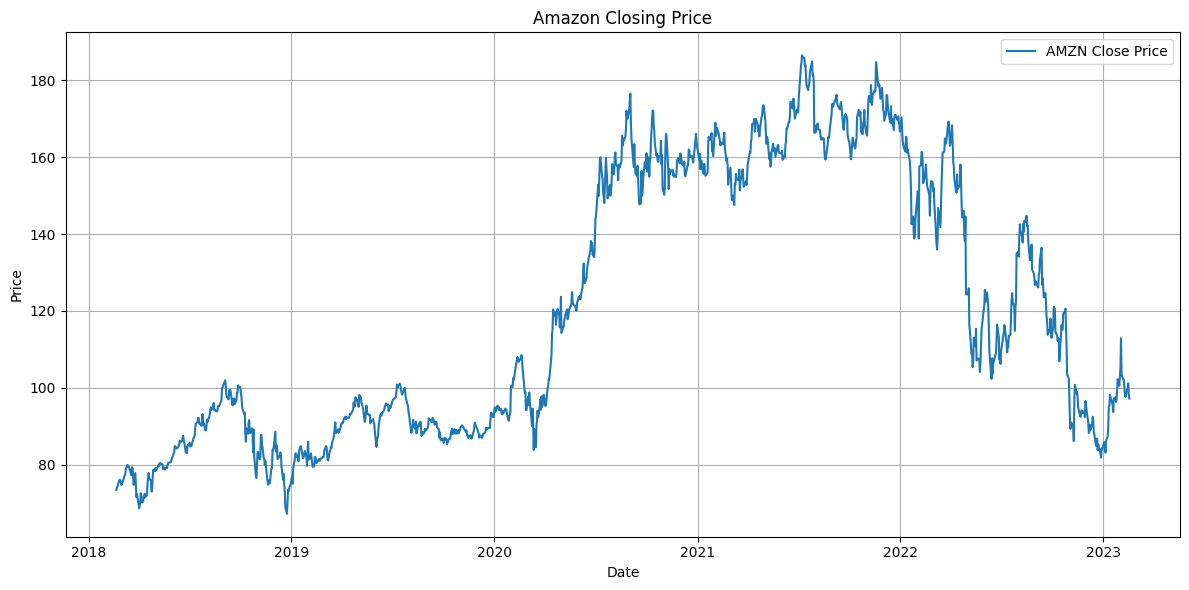

In [ ]:

# Load and Visualize the Data
df = pd.read_csv("AMZN.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Close']]

plt.figure(figsize=(12, 6))
plt.plot(data, label='AMZN Close Price')
plt.title('Amazon Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Stationarity Tests**

In [ ]:

# Stationarity Tests
adf_result = adfuller(data['Close'])
kpss_result = kpss(data['Close'], regression='c', nlags="auto")
print("ADF p-value:", adf_result[1])
print("KPSS p-value:", kpss_result[1])


ADF p-value: 0.45297105465166737
KPSS p-value: 0.01


In [ ]:

# Differencing
diff_data = data.diff().dropna()
adf_result_diff = adfuller(diff_data['Close'])
kpss_result_diff = kpss(diff_data['Close'], regression='c', nlags="auto")
print("ADF after differencing p-value:", adf_result_diff[1])
print("KPSS after differencing p-value:", kpss_result_diff[1])

ADF after differencing p-value: 0.0
KPSS after differencing p-value: 0.1


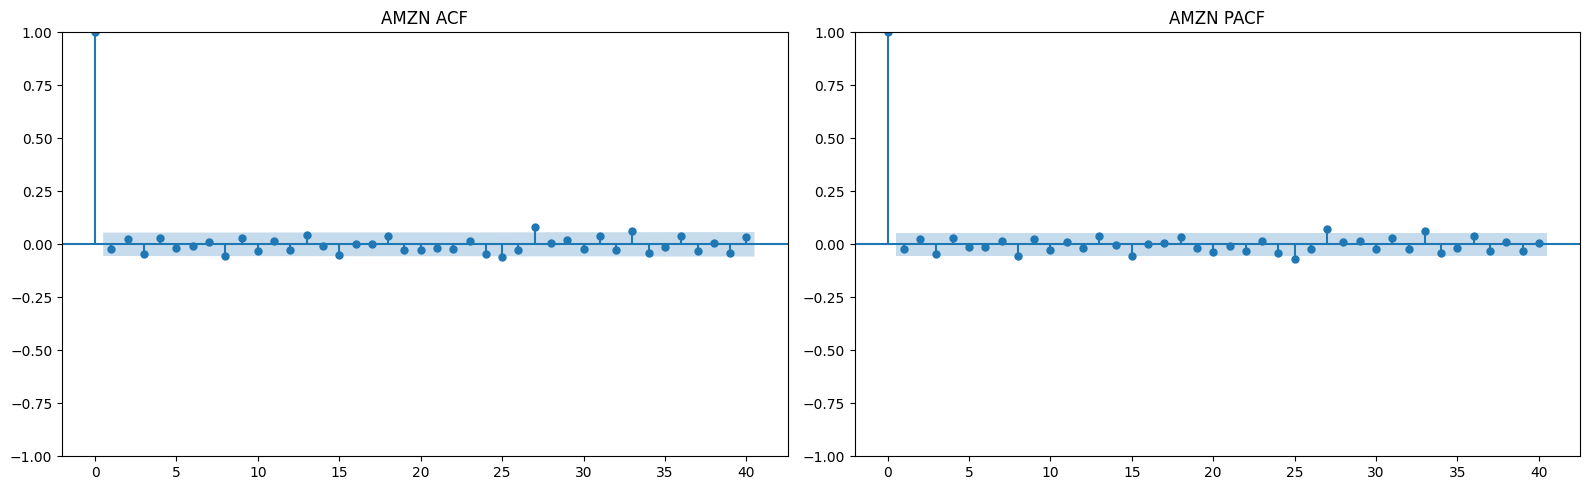

In [ ]:

# ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_data, lags=40, ax=axes[0])
axes[0].set_title("AMZN ACF")
plot_pacf(diff_data, lags=40, ax=axes[1])
axes[1].set_title("AMZN PACF")
plt.tight_layout()
plt.show()

## **ARIMA Model**

In [ ]:



# ARIMA Model Selection (p=0–3, d=1, q=0–3)
lowest_aic = float("inf")
best_order = None
best_model = None
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(data['Close'], order=(p, 1, q)).fit()
            if model.aic < lowest_aic:
                best_order = (p, 1, q)
                best_model = model
                lowest_aic = model.aic
        except:
            pass

print("Best ARIMA Order:", best_order)


Best ARIMA Order: (2, 1, 2)


In [ ]:
# Forecast for 24 months ≈ 730 calendar days
forecast = best_model.get_forecast(steps=730)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=730, freq='D')



### **ARIMA MODEL Performence**

In [ ]:

# Split real data into train/test (last 24 for test)
test_size = 24
train_data = data[:-test_size]
test_data = data[-test_size:]

#  ARIMA on training data
best_model = ARIMA(train_data['Close'], order=best_order).fit()

# Forecast same number of steps as test data
forecast = best_model.get_forecast(steps=test_size)
forecast_mean = forecast.predicted_mean

#  Evaluate performance
arima_true = test_data['Close'].values
arima_pred = forecast_mean.values

mae = mean_absolute_error(arima_true, arima_pred)
rmse = mean_squared_error(arima_true, arima_pred) ** 0.5
mape = mean_absolute_percentage_error(arima_true, arima_pred)

print(" ARIMA Model Performance (on last 24 days):")
print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)



 ARIMA Model Performance (on last 24 days):
MAE: 2.9317572981266102
RMSE: 4.215809411920578
MAPE: 0.02851829819942503


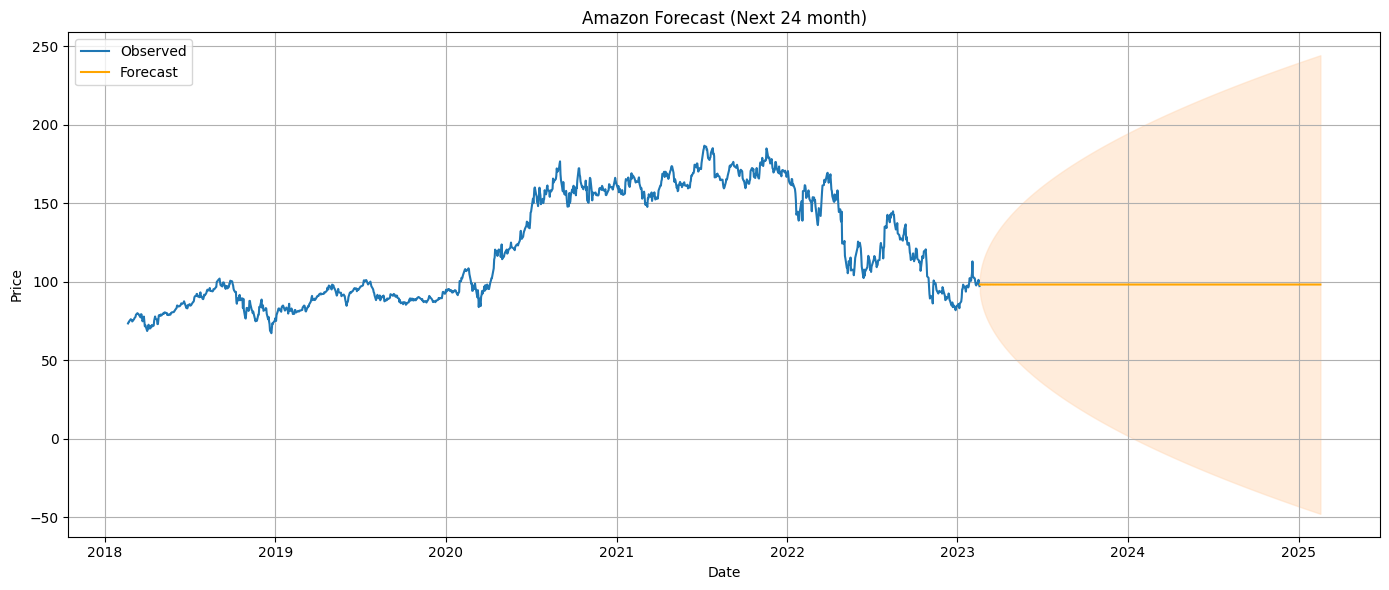

In [ ]:


# Plot Forecast
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Observed')
plt.plot(forecast_index, forecast_mean.values, label='Forecast', color='orange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='peachpuff', alpha=0.5)
plt.title('Amazon Forecast (Next 24 month)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Neural Network Model**

### **Normalize**

In [ ]:


# Normalize for LSTM/GRU
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

# ⛓ Sequence Creation
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_len = 60
X, y = create_sequences(data['Close'].values, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))


### **LSTM MODEL**

In [ ]:

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0758 - val_loss: 0.0043
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0

### **GRU MODEL**

In [ ]:

#  GRU Model
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1707 - val_loss: 0.0082
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0088 - val_loss: 0.0020
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 9.7833e-04 - val_loss: 0.0019
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 8.3836e-04 - val_loss: 0.0019
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 7.0397e-04 - val_loss: 0.0018
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 6.9243e-04 - val_loss: 0.0018
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.4708e-04 - val_loss: 0.0015
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 6.9634e-04 - val_loss: 0.0015
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 6.8164e-04 - val_loss: 0.0015
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 6.2543e-04 - val_loss: 0.0015
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.9212e-04 - val_loss: 0.0013
Epoch 12/50
30/30 ━━━━━━━━━

### **Preiction Forecasting**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


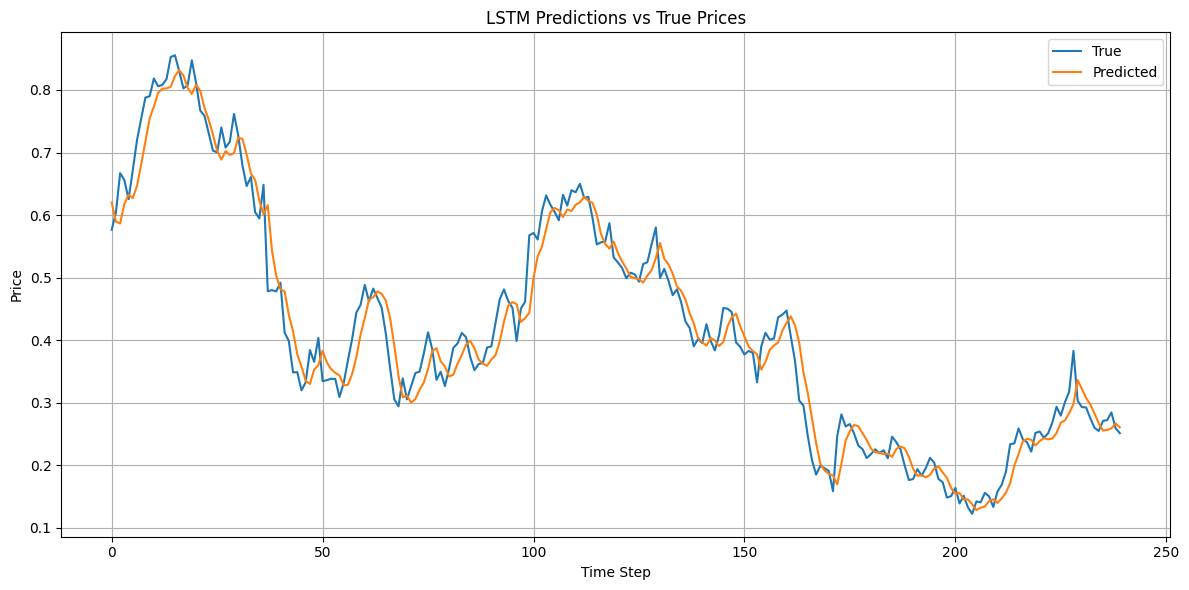

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


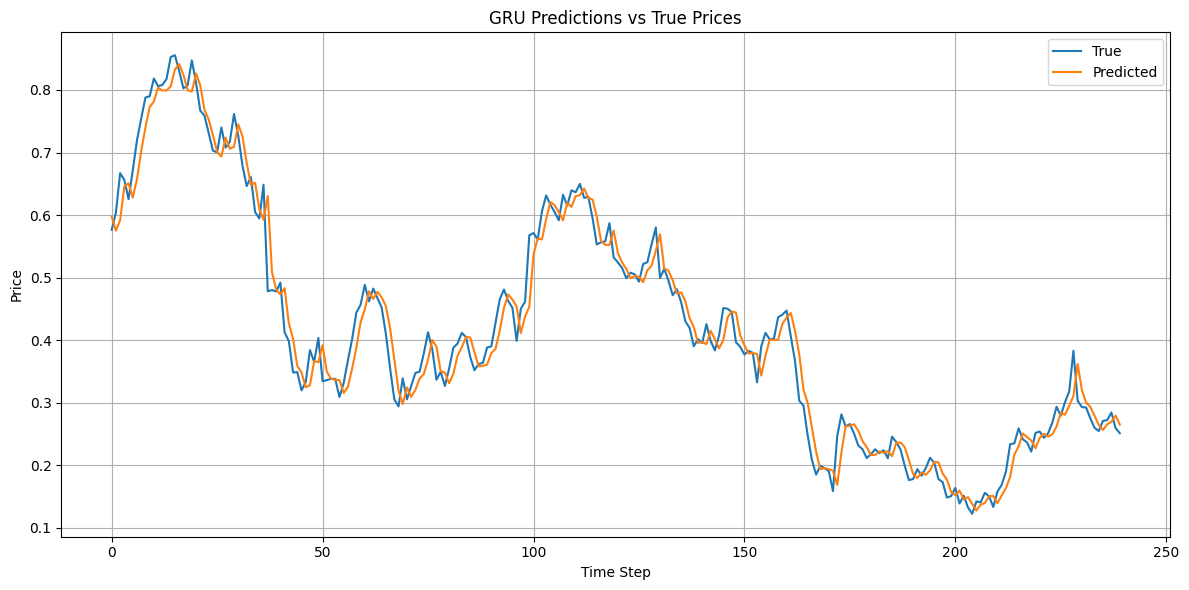

In [ ]:

#  Prediction Function
def plot_predictions(model, X_test, y_test, name="Model"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='True')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted')
    plt.title(f"{name} Predictions vs True Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Plot Results
plot_predictions(lstm_model, X_test, y_test, "LSTM")
plot_predictions(gru_model, X_test, y_test, "GRU")


### **LSTM and GRU performence**

In [ ]:
# Predict on test set
lstm_pred_scaled = lstm_model.predict(X_test)

# Inverse transform to original scale
lstm_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

# Metrics
mae_lstm = mean_absolute_error(lstm_true, lstm_pred)
rmse_lstm = np.sqrt(mean_squared_error(lstm_true, lstm_pred))
mape_lstm = mean_absolute_percentage_error(lstm_true, lstm_pred)

print("LSTM Model Performance:")
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)
print("MAPE:", mape_lstm)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM Model Performance:
MAE: 0.028790961388194404
RMSE: 0.036645481601042224
MAPE: 0.07844147477854453


In [ ]:

# Predict with GRU
gru_pred_scaled = gru_model.predict(X_test)

# Inverse transform predictions and true labels
gru_pred = scaler.inverse_transform(gru_pred_scaled).flatten()
gru_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
mae_gru = mean_absolute_error(gru_true, gru_pred)
rmse_gru = np.sqrt(mean_squared_error(gru_true, gru_pred))
mape_gru = mean_absolute_percentage_error(gru_true, gru_pred)

# Print results
print("GRU Model Performance on Test Set:")
print("MAE :", mae_gru)
print("RMSE:", rmse_gru)
print("MAPE:", mape_gru)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
GRU Model Performance on Test Set:
MAE : 0.024467638722888898
RMSE: 0.031984803750214404
MAPE: 0.06662603958937767


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1

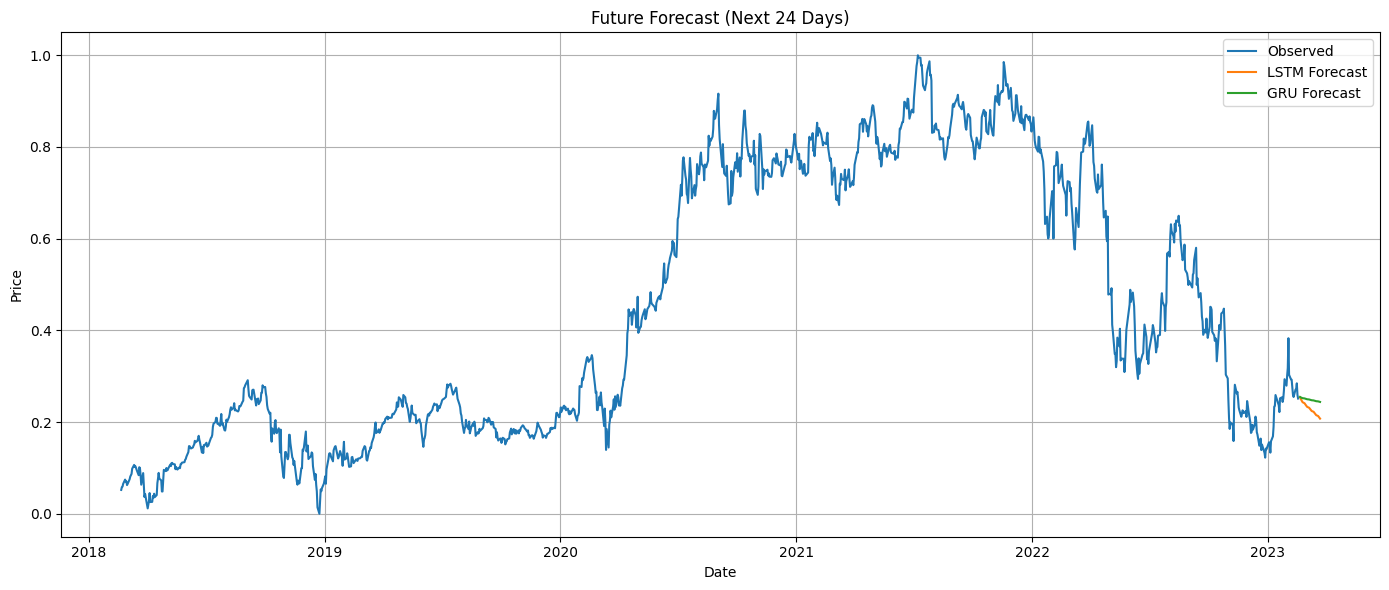

In [ ]:
def forecast_future(model, data_scaled, n_future=24, seq_len=60):
    last_sequence = data_scaled[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(n_future):
        pred = model.predict(last_sequence)[0][0]
        forecast.append(pred)

        # Append and slide the window
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

# Forecast 24 future days
future_lstm = forecast_future(lstm_model, data['Close'].values, n_future=24)
future_gru = forecast_future(gru_model, data['Close'].values, n_future=24)

# Plot future predictions
future_dates = pd.date_range(start=data.index[-1], periods=25, freq='B')[1:]

plt.figure(figsize=(14, 6))
plt.plot(data.index, scaler.inverse_transform(data['Close'].values.reshape(-1, 1)), label='Observed')
plt.plot(future_dates, future_lstm, label='LSTM Forecast')
plt.plot(future_dates, future_gru, label='GRU Forecast')
plt.title('Future Forecast (Next 24 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ***JJ.csv File***


## **Load and Visualize the Data**

In [ ]:

df = pd.read_csv("jj.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[['data']].rename(columns={'data': 'Close'})

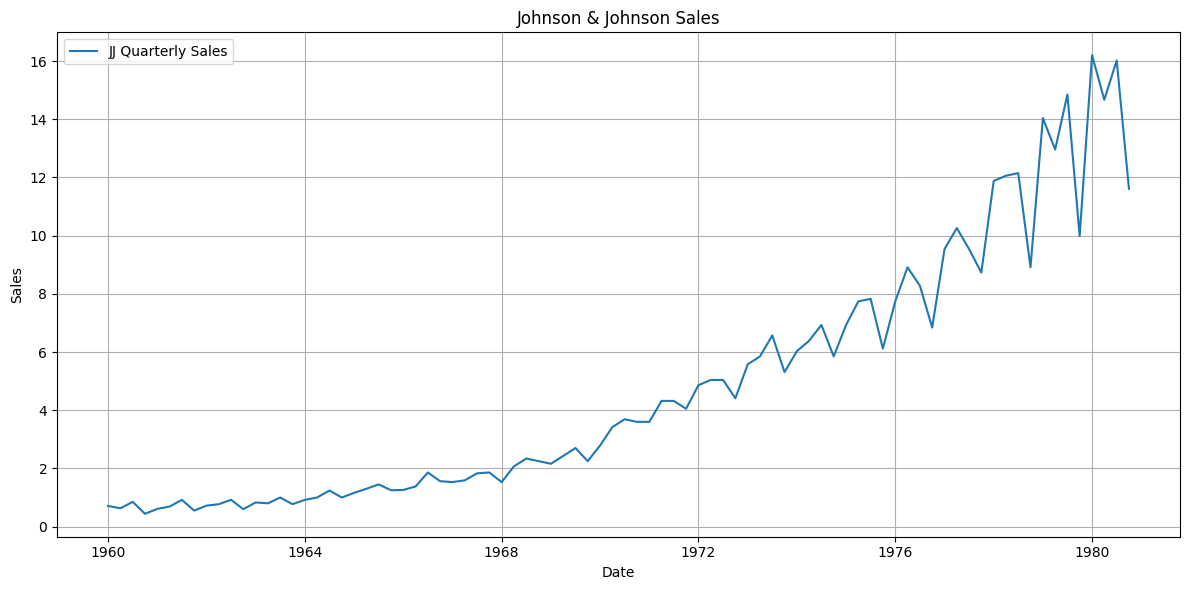

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='JJ Quarterly Sales')
plt.title('Johnson & Johnson Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# Stationarity Tests
adf_result = adfuller(data['Close'])
kpss_result = kpss(data['Close'], regression='c', nlags="auto")
print("ADF p-value:", adf_result[1])
print("KPSS p-value:", kpss_result[1])


ADF p-value: 1.0
KPSS p-value: 0.01


In [ ]:

# Differencing
diff_data = data.diff().dropna().diff().dropna()
adf_result_diff = adfuller(diff_data['Close'])
kpss_result_diff = kpss(diff_data['Close'], regression='c', nlags="auto")
print("ADF after differencing p-value:", adf_result_diff[1])
print("KPSS after differencing p-value:", kpss_result_diff[1])


ADF after differencing p-value: 0.006051099869603682
KPSS after differencing p-value: 0.1


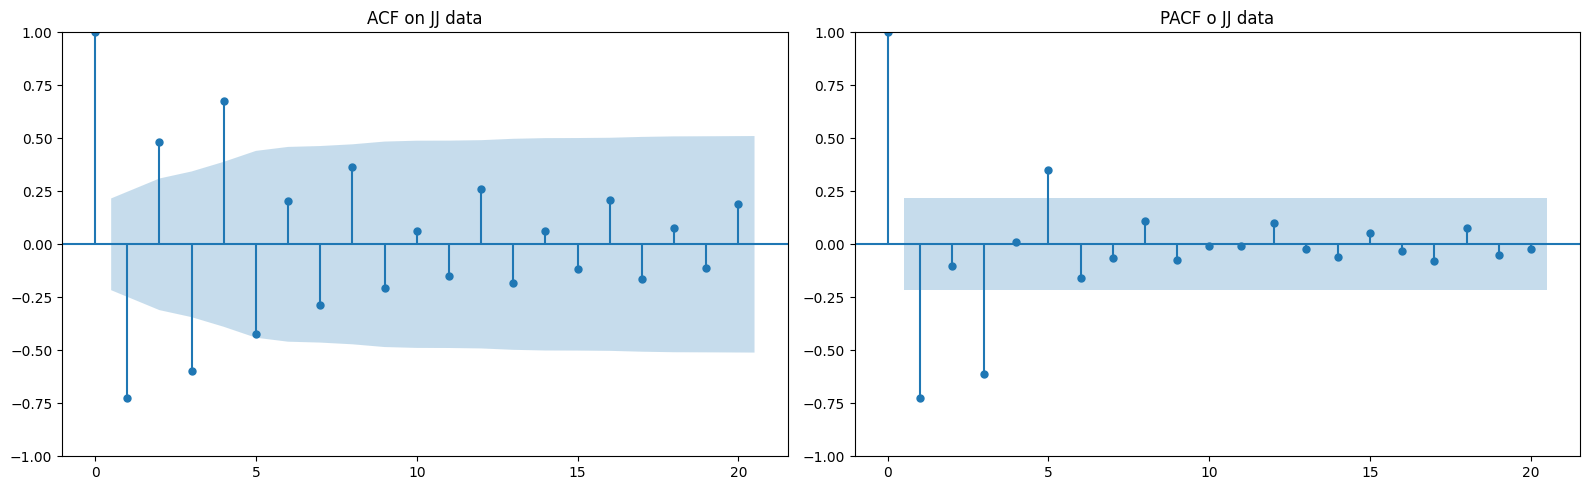

In [ ]:

#  ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_data, lags=20, ax=axes[0])
axes[0].set_title("ACF on JJ data")
plot_pacf(diff_data, lags=20, ax=axes[1])
axes[1].set_title("PACF o JJ data")
plt.tight_layout()
plt.show()


### **ARIMA Model**

In [ ]:


# ARIMA Model Selection (p=0–3, d=2, q=0–3)
lowest_aic = float("inf")
best_order = None
best_model = None
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(data['Close'], order=(p, 2, q)).fit()
            if model.aic < lowest_aic:
                best_order = (p, 2, q)
                best_model = model
                lowest_aic = model.aic
        except:
            pass

print("Best ARIMA Order:", best_order)

Best ARIMA Order: (3, 2, 3)


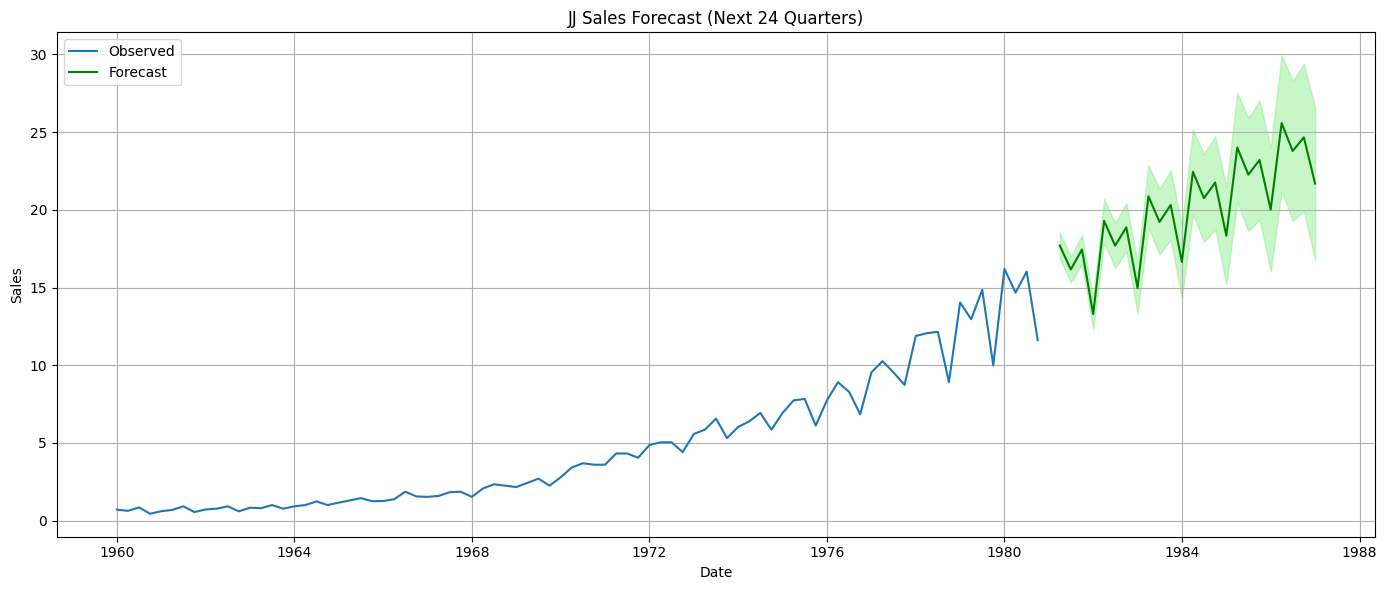

In [ ]:
# Forecast Next 24 Quarters
forecast = best_model.get_forecast(steps=8)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date, periods=8, freq='Q')[1:]

# Plot Forecast
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Observed')
plt.plot(forecast_index, forecast_mean.values, label='Forecast', color='green')
plt.fill_between(forecast_index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='lightgreen', alpha=0.5)
plt.title('JJ Sales Forecast (Next 24 Quarters)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 ARIMA Model Performance (on last 24 days):
MAE: 0.1898525347778861
RMSE: 0.24043676992683685
MAPE: 0.25494395586810903


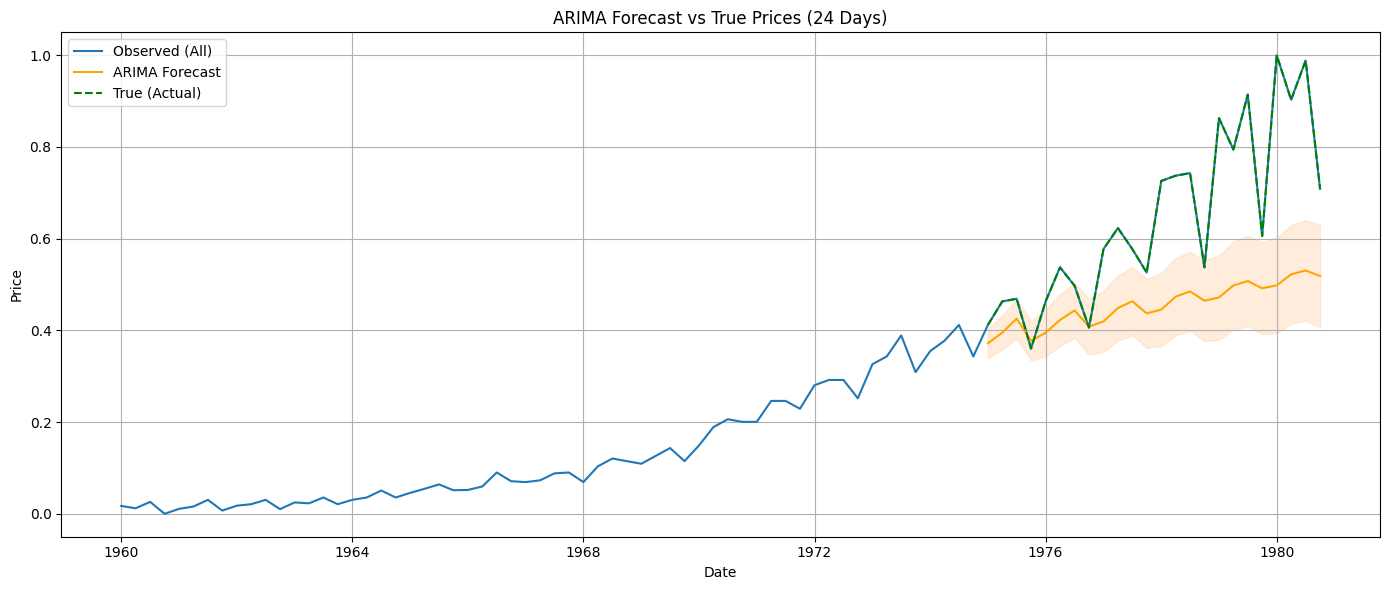

In [ ]:

# Split real data into train/test (last 24 for test)
test_size = 24
train_data = data[:-test_size]
test_data = data[-test_size:]

#  ARIMA on training data
best_model = ARIMA(train_data['Close'], order=best_order).fit()

# Forecast same number of steps as test data
forecast = best_model.get_forecast(steps=test_size)
forecast_mean = forecast.predicted_mean

#  Evaluate performance
arima_true = test_data['Close'].values
arima_pred = forecast_mean.values

mae = mean_absolute_error(arima_true, arima_pred)
rmse = mean_squared_error(arima_true, arima_pred) ** 0.5
mape = mean_absolute_percentage_error(arima_true, arima_pred)

print(" ARIMA Model Performance (on last 24 days):")
print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

# Plot again with true vs forecast
forecast_index = test_data.index

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Observed (All)')
plt.plot(forecast_index, arima_pred, label='ARIMA Forecast', color='orange')
plt.plot(forecast_index, arima_true, label='True (Actual)', color='green', linestyle='dashed')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='peachpuff', alpha=0.5)
plt.title('ARIMA Forecast vs True Prices (24 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Deep Neural Network**

### **Normalize and train test split**

In [ ]:


# Normalize for LSTM/GRU
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

# Sequence Creation
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_len = 12
X, y = create_sequences(data['Close'].values, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


### **LSTM MODEL**

In [ ]:
#  LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8, callbacks=[early_stop], verbose=1)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0367 - val_loss: 0.1962
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0125 - val_loss: 0.0210
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - val_loss: 0.0340
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - val_loss: 0.0302
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - val_loss: 0.0171
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017 - val_loss: 0.0178
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0181
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.8429e-04 - val_loss: 0.0170
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - val_loss: 0.0183


In [ ]:




# GRU Model
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8, callbacks=[early_stop], verbose=1)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0556 - val_loss: 0.3533
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0263 - val_loss: 0.1483
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0124 - val_loss: 0.0586
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0096 - val_loss: 0.0840
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0055 - val_loss: 0.0658
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - val_loss: 0.0230
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - val_loss: 0.0179
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0189
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 0.0180
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012 - val_loss: 0.0177
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.5988e-04 - val_loss: 0.0178
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 0.01

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


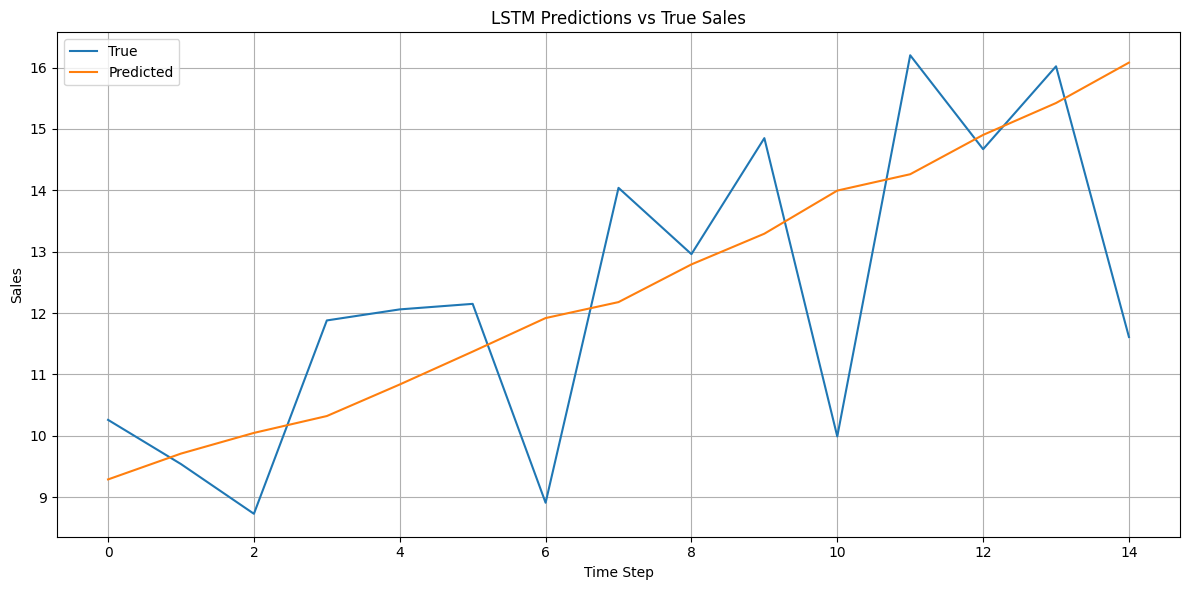

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


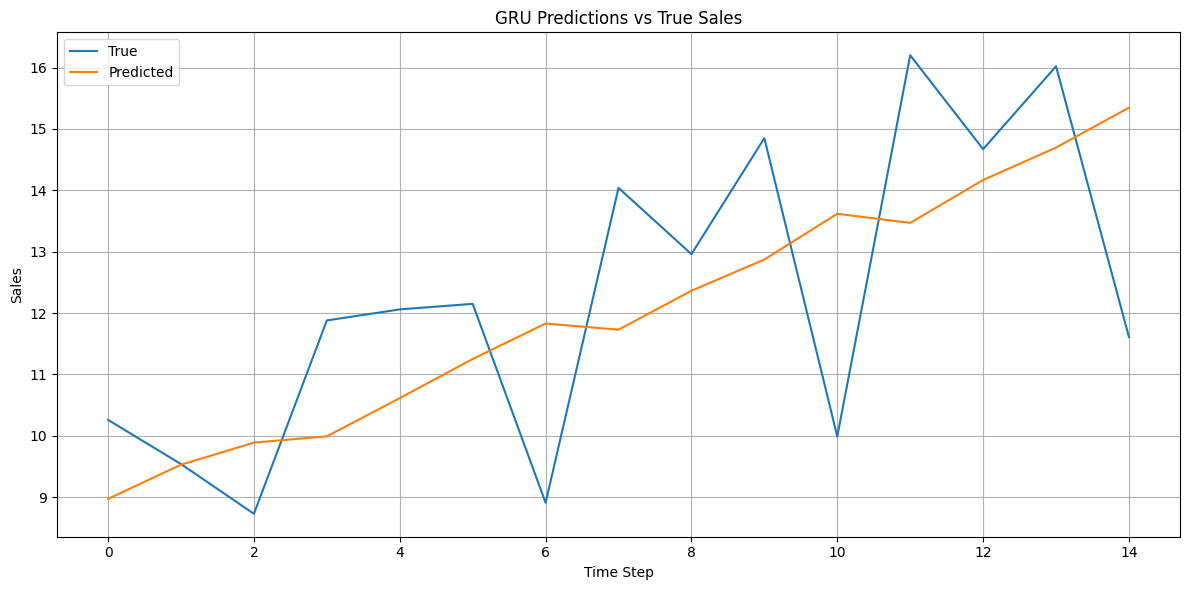

In [ ]:



#  Prediction Function
def plot_predictions(model, X_test, y_test, name="Model"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='True')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted')
    plt.title(f"{name} Predictions vs True Sales")
    plt.xlabel("Time Step")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Plot Results
plot_predictions(lstm_model, X_test, y_test, "LSTM")
plot_predictions(gru_model, X_test, y_test, "GRU")



### **LSTM and GRU performence**

In [ ]:
# Predict on test set
lstm_pred_scaled = lstm_model.predict(X_test)

# Inverse transform to original scale
lstm_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

# Metrics
mae_lstm = mean_absolute_error(lstm_true, lstm_pred)
rmse_lstm = np.sqrt(mean_squared_error(lstm_true, lstm_pred))
mape_lstm = mean_absolute_percentage_error(lstm_true, lstm_pred)

print("LSTM Model Performance:")
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)
print("MAPE:", mape_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LSTM Model Performance:
MAE: 1.5903493734090168
RMSE: 2.0395536038517297
MAPE: 0.1404470949706483


In [ ]:

# Predict with GRU
gru_pred_scaled = gru_model.predict(X_test)

# Inverse transform predictions and true labels
gru_pred = scaler.inverse_transform(gru_pred_scaled).flatten()
gru_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate metrics
mae_gru = mean_absolute_error(gru_true, gru_pred)
rmse_gru = np.sqrt(mean_squared_error(gru_true, gru_pred))
mape_gru = mean_absolute_percentage_error(gru_true, gru_pred)

# Print results
print("GRU Model Performance on Test Set:")
print("MAE :", mae_gru)
print("RMSE:", rmse_gru)
print("MAPE:", mape_gru)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
GRU Model Performance on Test Set:
MAE : 1.7609367172607422
RMSE: 2.068430029734483
MAPE: 0.15026007218278298


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━

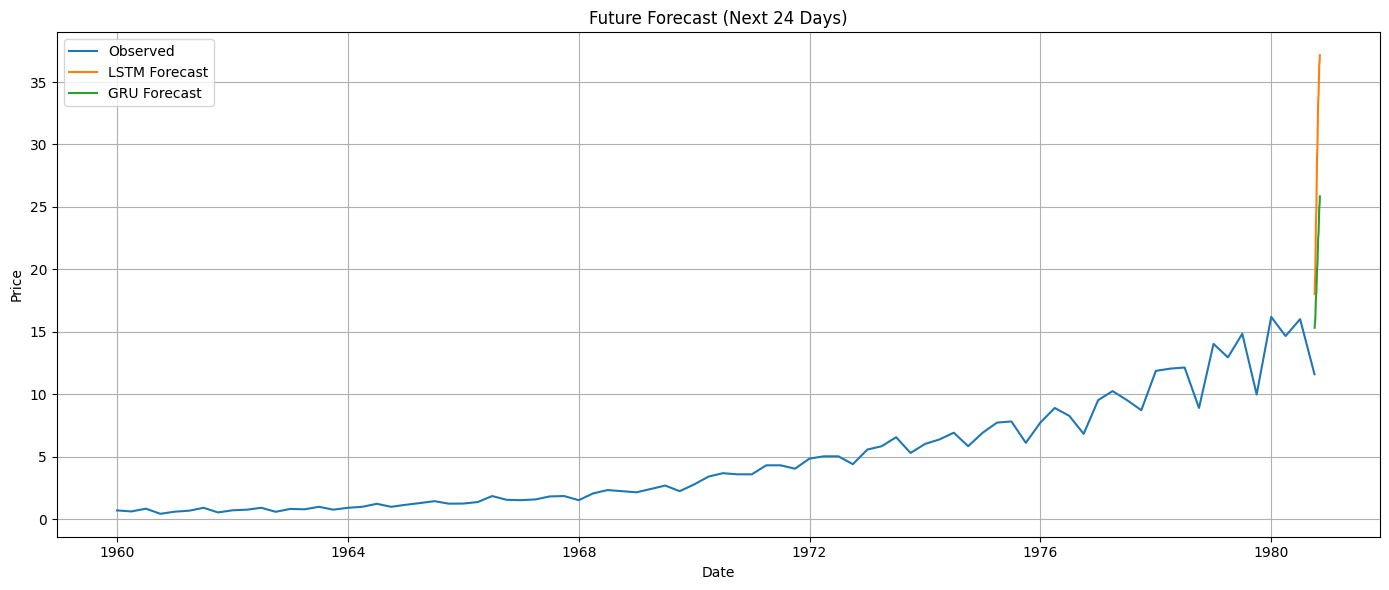

In [ ]:
def forecast_future(model, data_scaled, n_future=24, seq_len=60):
    last_sequence = data_scaled[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(n_future):
        pred = model.predict(last_sequence)[0][0]
        forecast.append(pred)

        # Append and slide the window
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

# Forecast 24 future days
future_lstm = forecast_future(lstm_model, data['Close'].values, n_future=24)
future_gru = forecast_future(gru_model, data['Close'].values, n_future=24)

# Plot future predictions
future_dates = pd.date_range(start=data.index[-1], periods=25, freq='B')[1:]

plt.figure(figsize=(14, 6))
plt.plot(data.index, scaler.inverse_transform(data['Close'].values.reshape(-1, 1)), label='Observed')
plt.plot(future_dates, future_lstm, label='LSTM Forecast')
plt.plot(future_dates, future_gru, label='GRU Forecast')
plt.title('Future Forecast (Next 24 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
